# Local Image Classification Training - Bars

Classifies the bars to extract the bits they represent.

In [1]:
BARS_FOLDER = "../bars/"
TRAIN_FOLDER = "../bars/train/"
TEST_FOLDER = "../bars/test/"
AUGMENT_FOLDER = "../bars/augmented/"
PARTITION_SCRIPT = "../tensorflow/scripts/preprocessing/partition_dataset.py"

In [2]:
import pandas as pd
from os import listdir
from os.path import isfile, join
import os

## Use the Utility Script to Split the Images

In [ ]:
!python {PARTITION_SCRIPT} -i {BARS_FOLDER} -r 0.1

In [3]:
train_paths = [TRAIN_FOLDER + f for f in listdir(TRAIN_FOLDER) if isfile(join(TRAIN_FOLDER, f))]
test_paths = [TEST_FOLDER + f for f in listdir(TEST_FOLDER) if isfile(join(TEST_FOLDER, f))]

In [ ]:
augment_paths = [AUGMENT_FOLDER + f for f in listdir(AUGMENT_FOLDER) if isfile(join(AUGMENT_FOLDER, f))]

In [ ]:
# copy flipped images to test and train (they are not jsut splitted with the line above
# to reduce correlation of training and validation data)
for t in train_paths:
    code = t.split("/")[-1].split("_")[0]
    
    for a in augment_paths:
        if a.split("/")[-1].split(".")[0].split("_")[-1] == code:
            os.rename(a, TRAIN_FOLDER + a.split("/")[-1])
            
for t in test_paths:
    code = t.split("/")[-1].split("_")[0]
    
    for a in augment_paths:
        if a.split("/")[-1].split(".")[0].split("_")[-1] == code:
            os.rename(a, TEST_FOLDER + a.split("/")[-1])

## Create a DataFrame with Paths and Labels

In [4]:
train_df = pd.DataFrame({'path': train_paths})
train_df["dec"] = train_df.apply(lambda x: int(x['path'].split("/")[-1].split("_")[0]), axis=1)
train_df["bin"] = train_df.apply(lambda x: bin(x['dec']), axis=1)
train_df["class"] = train_df.apply(lambda x: [i for i in reversed(range(20)) if (x['dec'] & 1 << i) != 0], axis=1)
    
print(train_df.shape)
train_df.head()

(1780, 4)


,path,dec,bin,class
0,../bars/train/1000082_v_300079.png,1000082,0b11110100001010010010,"[19, 18, 17, 16, 14, 9, 7, 4, 1]"
1,../bars/train/1000160_h_1016272.png,1000160,0b11110100001011100000,"[19, 18, 17, 16, 14, 9, 7, 6, 5]"
2,../bars/train/1000183_hv_915487.png,1000183,0b11110100001011110111,"[19, 18, 17, 16, 14, 9, 7, 6, 5, 4, 2, 1, 0]"
3,../bars/train/1000235_v_871471.png,1000235,0b11110100001100101011,"[19, 18, 17, 16, 14, 9, 8, 5, 3, 1, 0]"
4,../bars/train/1002732_hv_242463.png,1002732,0b11110100110011101100,"[19, 18, 17, 16, 14, 11, 10, 7, 6, 5, 3, 2]"


In [5]:
test_df = pd.DataFrame({'path': test_paths})
test_df["dec"] = test_df.apply(lambda x: int(x['path'].split("/")[-1].split("_")[0]), axis=1)
test_df["bin"] = test_df.apply(lambda x: bin(x['dec']), axis=1)
test_df["class"] = test_df.apply(lambda x: [i for i in reversed(range(20)) if (x['dec'] & 1 << i) != 0], axis=1)
    
print(test_df.shape)
test_df.head()

(200, 4)


,path,dec,bin,class
0,../bars/test/1000767_h_1018431.png,1000767,0b11110100010100111111,"[19, 18, 17, 16, 14, 10, 8, 5, 4, 3, 2, 1, 0]"
1,../bars/test/1001347_v_794159.png,1001347,0b11110100011110000011,"[19, 18, 17, 16, 14, 10, 9, 8, 7, 1, 0]"
2,../bars/test/1002872_1.png,1002872,0b11110100110101111000,"[19, 18, 17, 16, 14, 11, 10, 8, 6, 5, 4, 3]"
3,../bars/test/1004288_h_1024768.png,1004288,0b11110101001100000000,"[19, 18, 17, 16, 14, 12, 9, 8]"
4,../bars/test/1007758_h_1019981.png,1007758,0b11110110000010001110,"[19, 18, 17, 16, 14, 13, 7, 3, 2, 1]"


## Define the Image Generators

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
train_datagen = ImageDataGenerator(
      rotation_range = 4,
      zoom_range = 0.02,
      brightness_range=[0.15,0.85],
      channel_shift_range=0.2,
      shear_range = 0.2,
      horizontal_flip = False,
      vertical_flip = False,
      fill_mode = 'nearest')

In [8]:
target_size = (450, 100)

In [9]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    directory = ".",
    target_size = target_size,
    batch_size = 64,
    x_col = 'path',
    y_col = 'class',
    class_mode = 'categorical')
#   save_to_dir = '../augmented_bars/'

Found 1780 validated image filenames belonging to 20 classes.


In [10]:
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = ".",
    target_size = target_size,
    shuffle = False,
    x_col = 'path',
    y_col = 'class',
    class_mode = 'categorical')

Found 200 validated image filenames belonging to 20 classes.


## Define the Model

### Load VGG16 model for transfer learning

In [25]:
from tensorflow.keras.applications.vgg19 import VGG19

model = VGG19(include_top=False, input_shape=(450,100,3))
model.trainable = False

In [12]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 450, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 450, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 450, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 225, 50, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 225, 50, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 225, 50, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 112, 25, 128)      0     

## Add custom Dense Layers

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, Model

x = model.get_layer('block4_pool').output #remove last conv layers block

# Flatten layer
flatten = layers.Flatten()

# Create output layer with 20 nodes and sigmoid activation to handle multiple classes and labels
bits_pred = layers.Dense(20, activation = 'sigmoid', name='bits_pred')

output = bits_pred(flatten(x))

# Create an instance of a Model
model_final = Model(model.input, output)

# compile
model_final.compile(loss = 'binary_crossentropy',
                    optimizer='adam',
                    metrics = [tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

In [14]:
model_final.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 450, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 450, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 450, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 225, 50, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 225, 50, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 225, 50, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 112, 25, 128)     

## Define early stopping

I want the model to stop, only when the model started overfitting

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta = 0, 
                               patience = 5, 
                               verbose = 1,
                               mode ='min', 
                               restore_best_weights = True)

## Train the model

In [27]:
callbacks = [early_stopping]
history = model_final.fit(
      train_generator,
      steps_per_epoch = 28,  
      epochs = 9999, # We only want the training to stop after the early stopping condition is met
      validation_data = test_generator,
      verbose = 2, 
      callbacks = callbacks)

Epoch 1/9999
28/28 - 48s - loss: 360.8841 - binary_accuracy: 0.6505 - val_loss: 155.6227 - val_binary_accuracy: 0.8125
Epoch 2/9999
28/28 - 46s - loss: 41.4699 - binary_accuracy: 0.9000 - val_loss: 53.4989 - val_binary_accuracy: 0.9202
Epoch 3/9999
28/28 - 47s - loss: 14.3978 - binary_accuracy: 0.9560 - val_loss: 40.2102 - val_binary_accuracy: 0.9343
Epoch 4/9999
28/28 - 47s - loss: 8.3597 - binary_accuracy: 0.9718 - val_loss: 36.0959 - val_binary_accuracy: 0.9420
Epoch 5/9999
28/28 - 46s - loss: 5.8753 - binary_accuracy: 0.9775 - val_loss: 44.4312 - val_binary_accuracy: 0.9325
Epoch 6/9999
28/28 - 46s - loss: 6.3378 - binary_accuracy: 0.9766 - val_loss: 45.0721 - val_binary_accuracy: 0.9322
Epoch 7/9999
28/28 - 47s - loss: 6.1906 - binary_accuracy: 0.9768 - val_loss: 52.9994 - val_binary_accuracy: 0.9347
Epoch 8/9999
28/28 - 47s - loss: 6.4562 - binary_accuracy: 0.9774 - val_loss: 55.9705 - val_binary_accuracy: 0.9295
Epoch 9/9999
Restoring model weights from the end of the best epoch

## Evaluate

In [17]:
import matplotlib.pyplot as plt

def plot_history(history):
    f = plt.figure(figsize = (15,6))

    ax = f.add_subplot(121)
    ax.plot(history.history['binary_accuracy'])
    ax.plot(history.history['val_binary_accuracy'])
    ax.legend(['training accuracy', 'validation accuracy'], 
              bbox_to_anchor = (0, 1.02, 1, 0.2), 
              loc = "lower left", 
              mode = "expand",
              ncol = 2)

    ax2 = f.add_subplot(122)
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.legend(['training loss', 'validation loss'],
               bbox_to_anchor = (0, 1.02, 1, 0.2),
               loc = "lower left",
               mode = "expand", 
               ncol = 2)

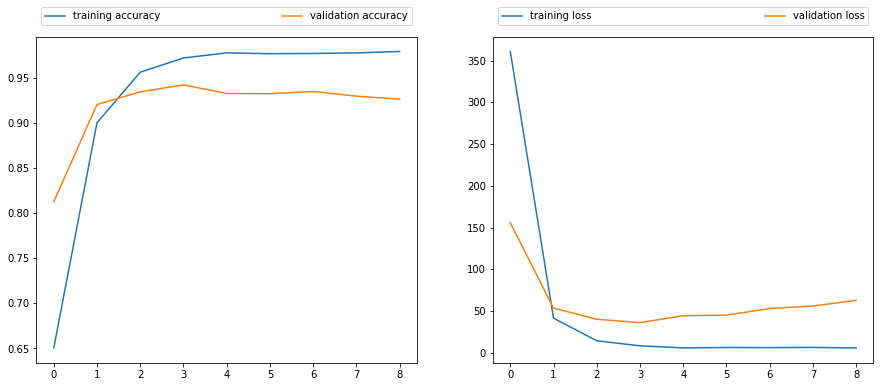

In [28]:
plot_history(history)

In [29]:
import numpy as np

pred_y = model_final.predict(test_generator)

In [30]:
pred_y = pred_y > 0.5
pred_y[0]

array([ True,  True,  True,  True,  True,  True, False, False,  True,
       False, False, False,  True, False,  True, False, False,  True,
        True,  True])

In [31]:
true_y = test_df['class']
true_y[0]

[19, 18, 17, 16, 14, 10, 8, 5, 4, 3, 2, 1, 0]

In [32]:
bt = [0] * 20
bf = [0] * 20
fp = [0] * 20
fn = [0] * 20

for t_y, p_y in zip(true_y, pred_y):
    p_y = np.where(p_y)[0]
    for i in range(20):
        if i in t_y and i in p_y:
            bt[i] += 1
        elif i not in t_y and i not in p_y:
            bf[i] += 1
        elif i in t_y and i not in p_y:
            fn[i] += 1
        else:
            fp[i] += 1
print("true positive:", bt, "\ntrue negative:", bf, "\nfalse positive:", fp, "\nfalse negative:", fn)

true positive: [114, 116, 96, 102, 81, 85, 90, 90, 99, 89, 94, 101, 90, 89, 87, 84, 99, 100, 110, 112] 
true negative: [72, 72, 96, 87, 107, 104, 98, 96, 90, 93, 93, 87, 101, 99, 101, 108, 91, 88, 77, 80] 
false positive: [11, 11, 1, 10, 4, 7, 5, 7, 9, 6, 6, 12, 2, 4, 10, 3, 6, 9, 6, 3] 
false negative: [3, 1, 7, 1, 8, 4, 7, 7, 2, 12, 7, 0, 7, 8, 2, 5, 4, 3, 7, 5]


In [33]:
model_final.evaluate(test_generator)

7/7 [==============================] - 3s 438ms/step - loss: 36.0959 - binary_accuracy: 0.9420


[36.095924377441406, 0.9419999718666077]

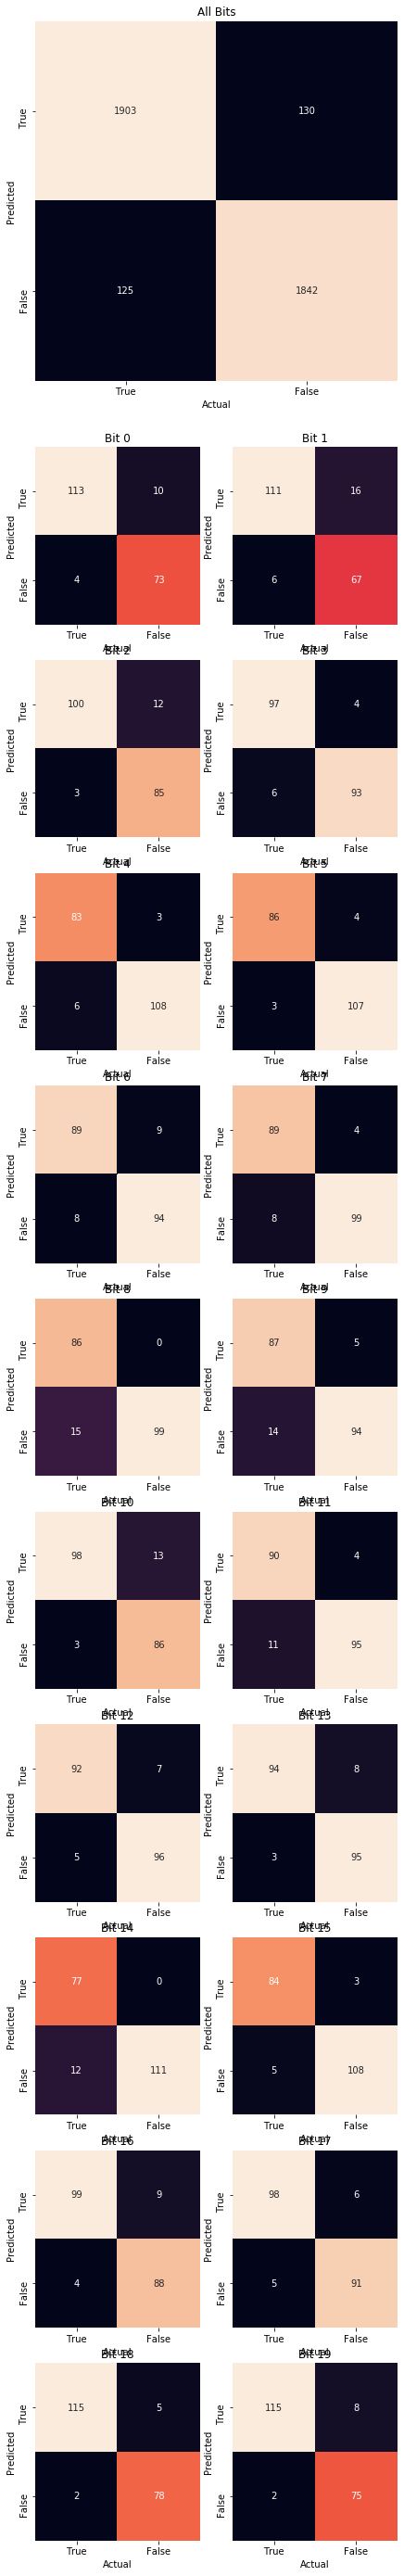

In [24]:
import seaborn as sns

f = plt.figure(figsize = (7,50))
sum_ax = f.add_subplot(6, 1, 1)
sns.heatmap([[sum(bt), sum(fp)], 
             [sum(fn), sum(bf)]],
            annot = True, 
            cbar = False,
            xticklabels = ["True", "False"], 
            yticklabels = ["True", "False"],
            ax = sum_ax,
            fmt='d')
sum_ax.set_title('All Bits')
sum_ax.set_ylabel("Predicted")
sum_ax.set_xlabel("Actual")

for i in range(20):
    ax = f.add_subplot(12, 2, i + 5)
    sns.heatmap([[bt[i], fp[i]], 
                 [fn[i], bf[i]]],
                annot = True, 
                cbar = False,
                xticklabels = ["True", "False"], 
                yticklabels = ["True", "False"],
                ax = ax,
                fmt='d')
    ax.set_title('Bit {}'.format(i))
    ax.set_ylabel("Predicted")
    ax.set_xlabel("Actual")

## Save model

In [ ]:
model_final.save('bar_cat_model_943')